# Simple epicenter estimation

## Brief description

This notebook intends to perform the estimation of the source parameters of an earthquake, more specifically the horizontal coordinates of an epicenter. 

An earthquake generates waves that propagate throughout the earth. These waves can be detected by a set of seismic stations positioned on the Earth's surface. All stations measure the difference of arrival times of $V_p$ and $V_s$ waves as their primary data.

For this reason, we can group the arrival times from all stations into a vector, called **Observed data vector**. Considering $N$ stations,

$$ \mathbf{d}^o = \begin{bmatrix} \Delta t_1 \\ \Delta t_2 \\ \vdots \\ \Delta t_N \end{bmatrix}$$

where $ \Delta t_i $ is the difference of arrival time of $V_p$ and $V_s$ at i-th station, $ i = 1,2,\dots, N$.

## Parametrization and Foward problem

First of all, we have to consider some assumptions that i) the ray paths is represented by a straight line, ii) the crust is homogeneous and isotropic and iii) assuming the approximation of a flat Earth surface.

Considering the arrival time as a function of :

* $V_p$ and $V_s$ (Wave velocities);

* $x_i$ and $y_i$ (Cartesian coordinates of i-th station);

* $x_0$ and $y_0$ (Epicenter Cartesian coordinates).

For this reason, the time arrival at the i-th station can be written as 

$$ \Delta t_i (\mathbf{p}) = \alpha [(x_i - x_0)^2 + (y_i - y_0)^2]^{1/2}\,$$

where,

$$\mathbf{p} = \begin{bmatrix} x_0 \\ y_0 \end{bmatrix}$$

that is the **parameter vector** and

$$ \alpha = \dfrac{1}{V_s} - \dfrac{1}{V_p} .$$

From of all equations above, we can write the ** predicted vector ** as

$$\mathbf{\Delta t} (\mathbf{p}) = \begin{bmatrix} \Delta t_1 (\mathbf{p}) \\ \Delta t_2 (\mathbf{p})\\ \vdots \\ \Delta t_N (\mathbf{p}) \end{bmatrix}.$$

## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Importing auxiliary functions

In [2]:
import functions as func

### Observation area

In [3]:
x_min = -40.
x_max = 40.

In [4]:
y_min = -50.
y_max = 50.

### True value for the epicenter

In [5]:
x0 = -4.
y0 = -20.

In [6]:
epicenter = [x0,y0]

In [7]:
p_real = np.array(epicenter)

### Station locations

In [8]:
x = np.array([30.,30.,-10.,-30.])
y = np.array([-40.,35.,20.,-40.])

### Seismic velocities

In [9]:
vp = 6.   # in km/s
vs = 3.4  # in km/s

## Observed data 

In [10]:
dt = func.time_arrival(x,y,p_real[0],p_real[1],vp,vs)

### Generating noise

In [11]:
np.random.seed(seed=40)

std_noise = 0.009


noise = np.random.normal(0.0, std_noise, dt.size)

print ('%.3f s' % std_noise)

0.009 s


In [12]:
dt_obs = dt + noise

### Calculating the Goal function

In [13]:
Nx = 20
x_range = np.linspace(x_min,x_max,num=Nx)

In [14]:
Ny = 20
y_range = np.linspace(y_min,y_max,num=Ny)

In [15]:
x_range,y_range = np.meshgrid(x_range,y_range)

In [16]:
shape_phi = (Nx,Ny)

In [17]:
goal = []
for xi,yi in zip (x_range.ravel(),y_range.ravel()):
    p = np.array([xi,yi])
    dt_it = func.time_arrival(x,y,p[0],p[1],vp,vs)
    res = dt_obs - dt_it 
    goal.append(np.linalg.norm(res))

## Inversion 

### Initial parameters for the inversion

In [18]:
itmax = 15
mu = 1e-4
p0 = np.array([10.,40.])

### Applying Levenberg-Marquardt Method 

In [19]:
p_est,px,py,phi,it = func.solver(dt_obs,x,y,p0[0],p0[1],vp,vs,itmax,mu)

In [20]:
print (p_est)

[ -3.94952886 -19.92333202]


In [21]:
print (p_real)

[ -4. -20.]


## Generating the map of the epicenter, seismic stations and goal function

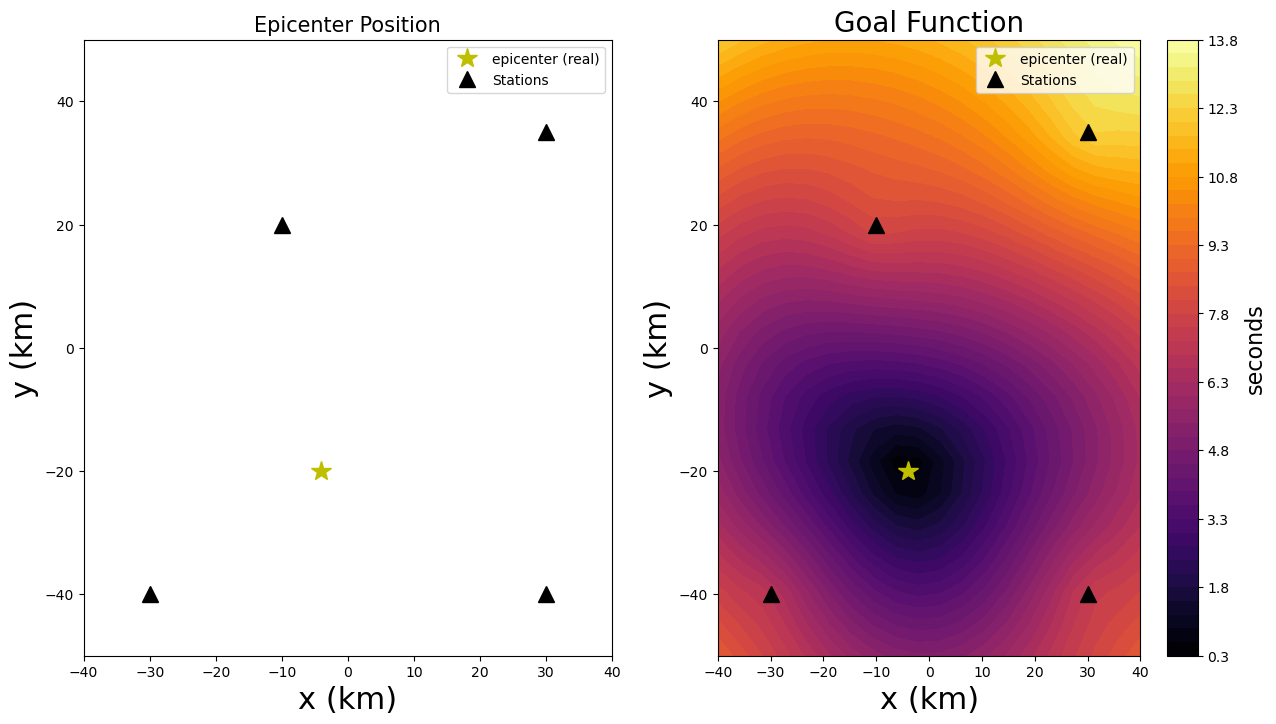

In [22]:
title_font = 22
bottom_font = 16
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.title('Epicenter Position', fontsize=15)
plt.plot(p_real[0],p_real[1], 'y*',markersize=15, label='epicenter (real)')
plt.plot(x,y,'k^',markersize=12, label='Stations') 
plt.xlabel('x (km)', fontsize = title_font)
plt.ylabel('y (km)', fontsize = title_font)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.legend(loc='best', numpoints=1)

plt.subplot(1,2,2)
plt.contourf(x_range, y_range, np.array(goal).reshape(shape_phi), 50,cmap='inferno')
cbar = plt.colorbar()
cbar.set_label('seconds', fontsize=16)
plt.plot(p_real[0],p_real[1], 'y*',markersize=15, label='epicenter (real)')
plt.plot(x,y,'k^',markersize=12, label='Stations')
plt.title('Goal Function', fontsize=20)
plt.xlabel('x (km)', fontsize = title_font)
plt.ylabel('y (km)', fontsize = title_font)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.legend(loc='best', numpoints=1)

plt.show()


## Visualization of estimates

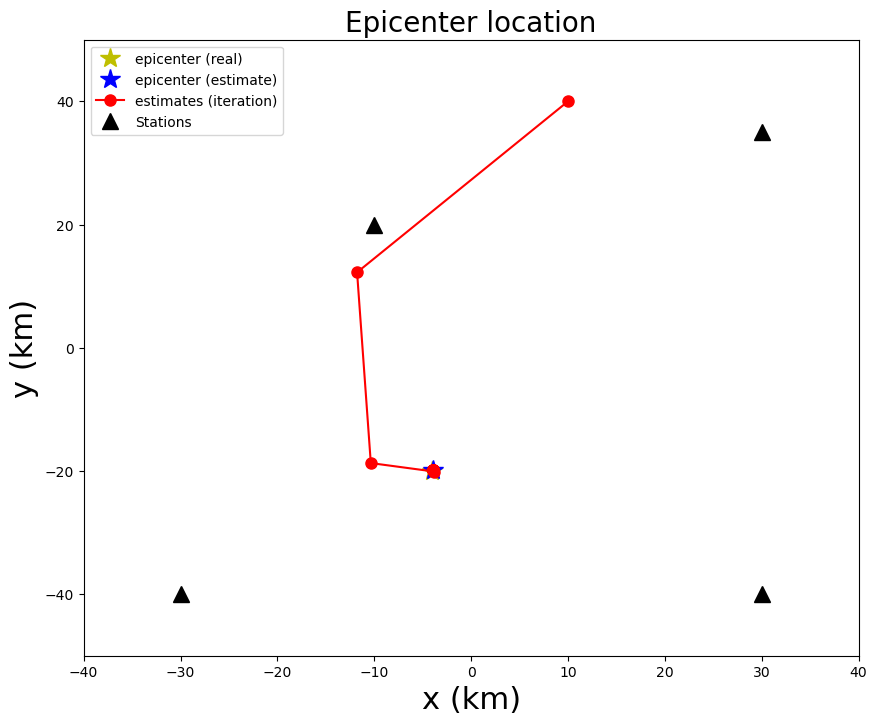

In [23]:
title_font = 22
bottom_font = 16
plt.figure(figsize=(10,8))
plt.plot(p_real[0],p_real[1], 'y*',markersize=15, label='epicenter (real)')
plt.plot(p_est[0],p_est[1], 'b*',markersize=15, label='epicenter (estimate)')
plt.plot(px,py, 'ro-',markersize=8, label='estimates (iteration)')
plt.plot(x,y,'k^',markersize=12, label='Stations')
plt.xlabel('x (km)', fontsize = title_font)
plt.ylabel('y (km)', fontsize = title_font)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.title('Epicenter location', fontsize=20)
plt.legend(loc='best', numpoints=1)
plt.show()


## Visualization of the convergence

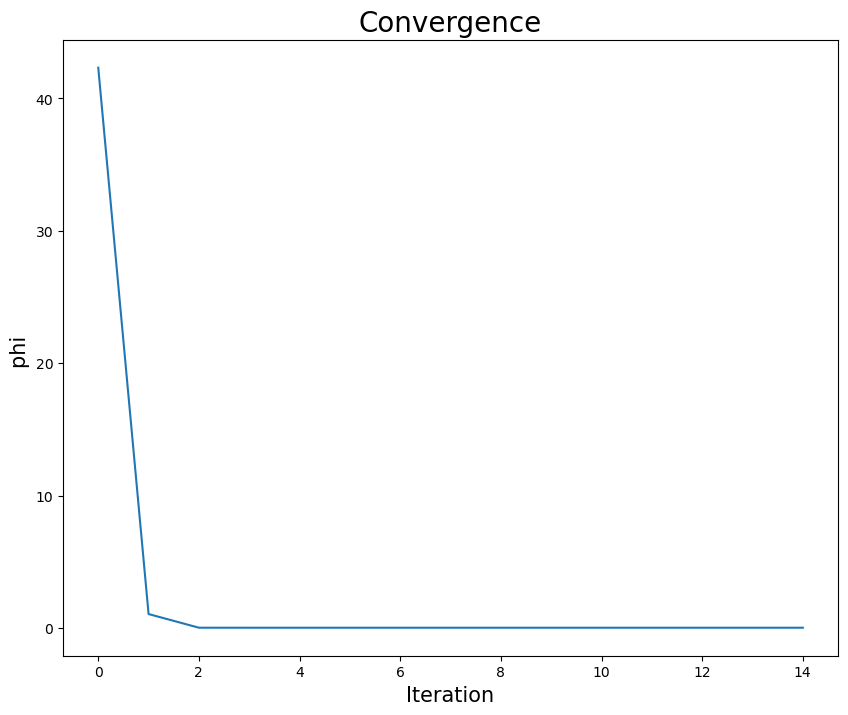

In [24]:
plt.figure(figsize=(10,8))
plt.plot(it, phi, '-')
plt.title('Convergence',fontsize=20)
plt.ylabel('phi ',fontsize=15)
plt.xlabel('Iteration',fontsize=15)
plt.show()